# Clustering des candidats sur l'ensemble des tweets du $1^{er}$ tour

### Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 999)
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation

import util

### Chargement des données

On importe les données et on ne garde que celles jusqu'au 1er tour.

In [2]:
df = util.import_data('../data/dataframe_full')
df = util.premier_tour(df)

On crée la liste $C$ des candidats et on désigne par $N$ le nombre de candidats.

In [3]:
C = ['Arthaud', 'Asselineau', 'Cheminade', 'Dupont-Aignan', 'Fillon',
     'Hamon','Lassalle','Le Pen','Macron','Melenchon','Poutou']
N = len(C) # le nombre de candidats

### Calcul des similarités entre candidats et graphe
On définit la similarité entre deux candidats $c_1$ et $c_2$ par 
$ similarite(c_1,c_2) := \frac{\text{2 }\times \text{ nombre de tweets mentionnant $c_1$ et $c_2$}}{\text{nombre de tweets mentionnant $c_1$ + nombre de tweets mentionnant $c_2$}} $

Les similarités sont rangées dans une matrice $S$ de dimension $N\times N$ telle que $S[i,j]$ donne la similarité entre le $i^{ème}$ et le $j^{ème}$ candidat de la liste $C$. Pour calculer ces valeurs on calcule d'abord pour chaque candidat le nombre de tweets le mentionnant. Puis on itère sur l'ensemble des tweets en augmentant de 2 la similarité entre $c_1$ et $c_2$ lorsqu'ils sont tous deux mentionnés dans un tweet. Enfin on divise les similarités par la somme du nombre de tweets de chacun des deux candidats.

In [4]:
# le nombre de tweets mentionnant chaque candidat
nb_tweets = { c:df.loc[df[c]==1].shape[0] for c in C }

# calcul similarités
S = np.zeros(shape=(N,N))
for i,tweet in df.iterrows():
    mentions = [c for c in C if tweet[c]==1]
    for c1 in mentions:
        for c2 in mentions:
            S[C.index(c1), C.index(c2)] += 2 / (nb_tweets[c1]+nb_tweets[c2])

On peut maintenant dessiner le graphe des candidats. Chaque candidat est représenté par un noeud de taille proportionnelle à la racine du nombre de tweets qui le mentionnent (on a pris la racine afin que les petits candidats restent visibles à côté des gros) et les noeuds sont reliés par des arêtes qui sont plus épaisses et plus foncées quand ils ont une grande similarité. On a également noté les pourcentages de tweets mentionnant chaque candidat.

D:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
D:\Anaconda\lib\site-packages\matplotlib\figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


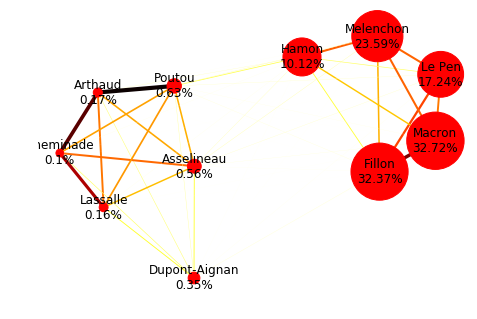

In [5]:
# création du graphe
G = nx.Graph()
for c1 in C:
    for c2 in C:
        if c1!=c2 and (c2, c1) not in G.edges:
            G.add_edge(c1, c2, weight=S[C.index(c1),C.index(c2)])

# on dessine le graphe
nbTweets_total = df.shape[0]
labels = { c:c+'\n'+str(round(100*nb_tweets[c]/nbTweets_total,2))+'%' for c in G.nodes }
nx.draw(G, with_labels=True, labels=labels, node_size=[nb_tweets[c]**0.7 for c in G.nodes], 
        width=[20*G[a][b]['weight'] for (a,b) in G.edges], 
        edge_color=[G[a][b]['weight'] for (a,b) in G.edges], edge_cmap=plt.cm.hot_r)

# on affiche
plt.tight_layout()

### Clustering
Pour faire le clustering, on transforme les matrices de similarités en matrices de distances. Comme le max des matrices de similarités est 1 (valeurs de la diagonale) on définit la matrice des distances $D$ par $D[i,j] = 1 - S[i,j]$. On force 0 sur la diagonale parce que python met des valeurs $\approx 10^{-17}$ au lieu de 0.

Ensuite on procède au clustering en utilisant l'algorithme Affinity Propagation avec la matrice de distances $D$ et on sauvegarde le résultat dans le dossier courant sous la forme d'un dictionnaire 

<center>$\text{{n°cluster : liste des membres du cluster}}$</center>

On a choisi de prendre un damping factor égal à 0.5 car il produit les résultats les plus intéressants.

In [6]:
# matrice des distances
D = np.full(shape=(N,N), fill_value=1) - S
np.fill_diagonal(D,0)

# affinity propagation
aff = AffinityPropagation(damping=0.9, affinity='precomputed')
clusters_aff = aff.fit_predict(D)

# résultat
for i in set(clusters_aff):
    print(i, [c for c in C if clusters_aff[C.index(c)]==i])

0 ['Cheminade', 'Fillon', 'Hamon', 'Le Pen', 'Melenchon']
1 ['Arthaud', 'Asselineau', 'Dupont-Aignan', 'Lassalle', 'Macron', 'Poutou']


D:\Anaconda\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full((11, 11), 1) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
